# Задание

1.Выберите ряд из первого задания.
    
2.Постройте его модель GARCHR.
    
3.Оформите отчёт в Jupyter-ноутбукт.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_predict

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [4]:
import os
os.listdir("Series/")
pd.read_csv('Series/monthly-boston-armed-robberies-j.csv').head()

,Month,Count
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43


Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


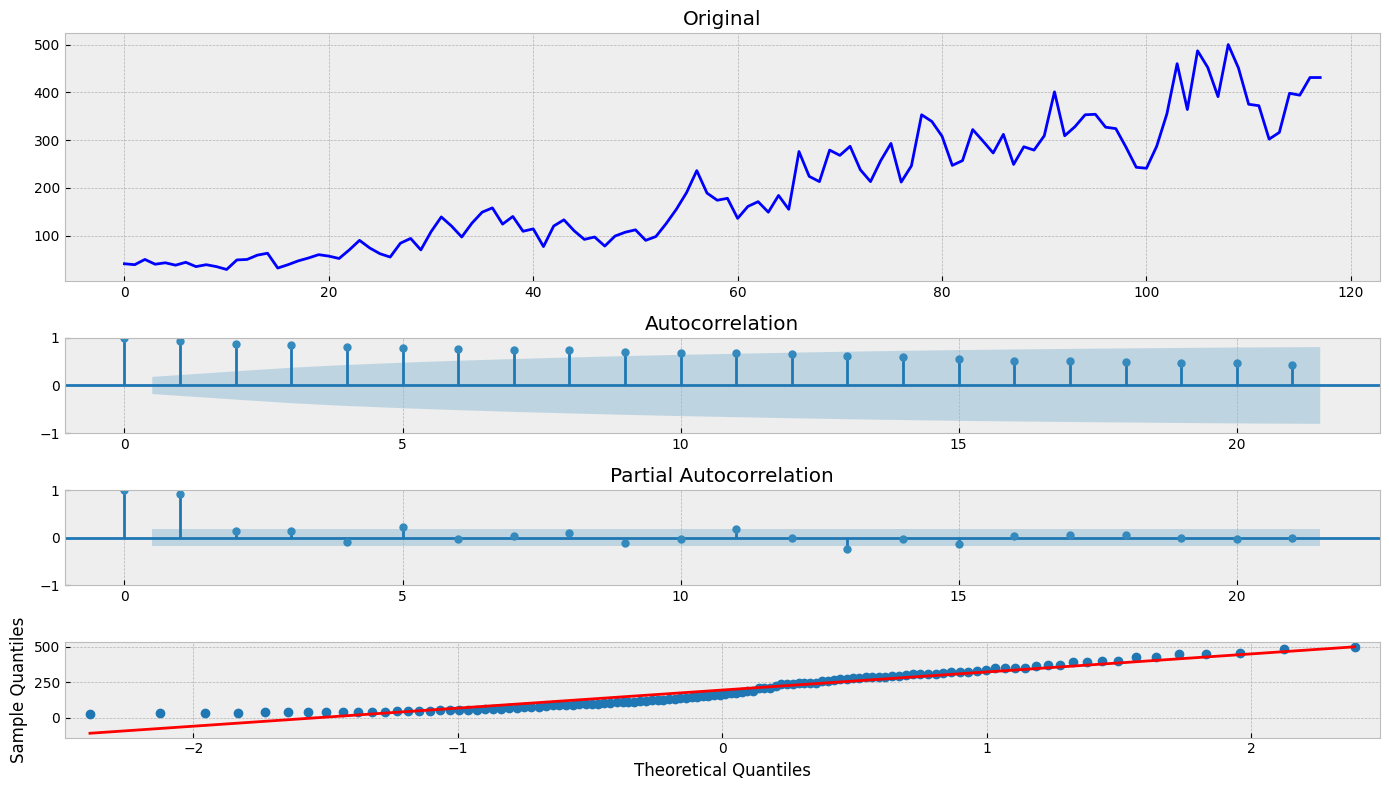

In [5]:
ts = pd.read_csv('Series/monthly-boston-armed-robberies-j.csv')['Count']
tsplot(ts)

In [6]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = arch_model(TS, vol='Garch', p=i, o=d, q=j, mean='ARX',power=1.0).fit(disp='off')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

ts = boxcox(ts, 0)
ts_diffed = np.diff(ts)

aic, order, mdl = _get_best_model(ts_diffed)

aic: -31.68686 | order: (0, 1, 0)


Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


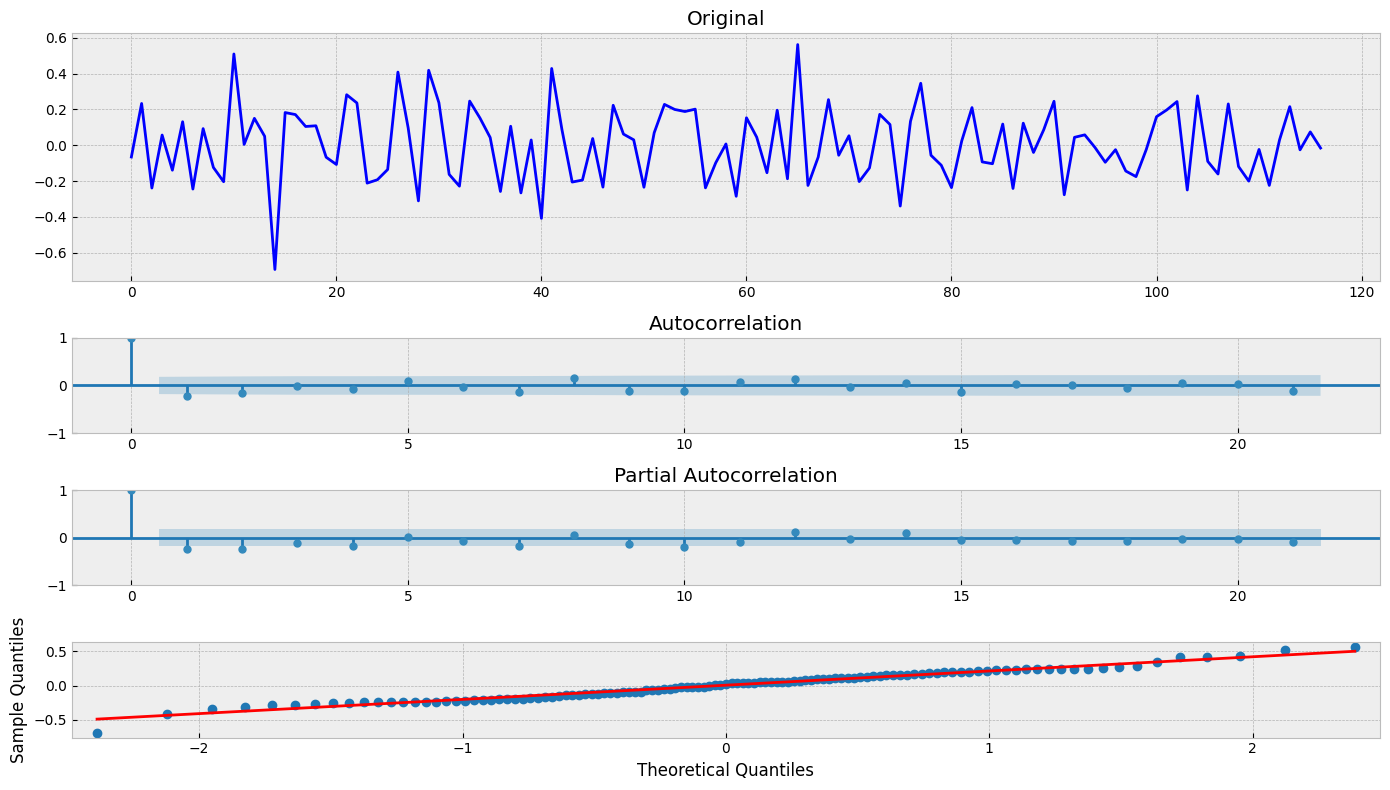

In [7]:
tsplot(mdl.resid)

In [8]:
mdl.params

Const       0.015415
omega       0.201013
gamma[1]    0.061259
Name: params, dtype: float64